We ignored all the sequence in the previous step, included a naive summary statistic as a feature. Trained linear regression, obtained half of the state of the art on this dataset. Not a bad start, eh?

Let's do something better, we want to capture the sequential statistics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
# import seaborn as sns
plt.rcParams['figure.figsize'] = 15, 12

In [2]:
d = pd.read_csv('data/DREAM5_PBM_Data_TrainingSet.txt', sep='\t')

In [3]:
d.head()

,TF_Id,ArrayType,Sequence,Signal_Mean,Background_Mean,Signal_Median,Background_Median,Signal_Std,Background_Std,Flag
0,Cebpb,HK,AAAAAACAACAGGAGGGCATCATGGAGCTGTCCAGCCTGTGTGAAA...,1508.7972,264.8014,1557.5,183.0,393.2445,249.7754,0
1,Cebpb,HK,AAAAAACAGCCGGATCACAATTTTGCCGAGAGCGACCTGTGTGAAA...,13630.7324,371.0260,14858.0,245.0,6451.2436,445.4670,0
2,Cebpb,HK,AAAAAACGTCCGGTACACCCCGTTCGGCGGCCCAGCCTGTGTGAAA...,1523.0000,265.7928,1571.5,194.5,439.6682,211.7982,0
3,Cebpb,HK,AAAAAACTCTAGACCTTTAGCCCATCGTTGGCCAACCTGTGTGAAA...,4992.8461,430.4496,5150.0,233.0,1629.2899,507.5433,0
4,Cebpb,HK,AAAAAAGAACAACCGGATAACACCCTTACAGCACACCTGTGTGAAA...,3539.8117,449.4453,3823.5,226.5,1063.9028,551.7675,0


In [4]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.autograd import Variable

In [ ]:
# no gpu@ system change!

I glanced some of the research papers that were published using this data, I think I got the problem statement wrong. For each individual TF, we have to train a separate model predicting the signal mean.

In [7]:
# d.ArrayType.value_counts()

In [5]:
d.TF_Id.value_counts()

Irf2       80856
Mecp2      80856
Sp1        80856
Pou3f1     80856
Tbx3       80856
Cebpb      80856
Esr1       80856
Zscan20    80856
Foxp2      80856
Foxp1      80856
Foxo3      80856
Foxo1      80856
Foxo4      80856
Tcf3       80856
Nr2c1      80856
Foxj2      80856
Egr2       80856
Gmeb2      80856
Junb       80856
Sox14      80856
Name: TF_Id, dtype: int64

I am selecting Sox14 for now.

In [8]:
d = d[d.TF_Id == 'Sox14']

In [12]:
d.ArrayType.value_counts()

ME    40526
HK    40330
Name: ArrayType, dtype: int64

In [13]:
d.head()

,TF_Id,ArrayType,Sequence,Signal_Mean,Background_Mean,Signal_Median,Background_Median,Signal_Std,Background_Std,Flag
1212840,Sox14,HK,AAAAAACAACAGGAGGGCATCATGGAGCTGTCCAGCCTGTGTGAAA...,4689.7988,728.5694,5097.0,421.5,1215.5156,795.3395,0
1212841,Sox14,HK,AAAAAACAGCCGGATCACAATTTTGCCGAGAGCGACCTGTGTGAAA...,7601.9057,1117.3750,8022.0,446.5,1220.7102,1297.0731,0
1212842,Sox14,HK,AAAAAACGTCCGGTACACCCCGTTCGGCGGCCCAGCCTGTGTGAAA...,3450.9868,460.4931,3810.5,264.5,980.1734,522.8422,0
1212843,Sox14,HK,AAAAAACTCTAGACCTTTAGCCCATCGTTGGCCAACCTGTGTGAAA...,6405.0585,852.9558,6765.0,354.0,1394.2091,1071.4765,0
1212844,Sox14,HK,AAAAAAGAACAACCGGATAACACCCTTACAGCACACCTGTGTGAAA...,7719.7729,631.4874,8300.0,288.5,2351.0661,923.0020,0


I am using 'HK' array type for training the model, and 'ME' for validating the model.

In [14]:
train = d[d.ArrayType == 'HK']
test = d[d.ArrayType == 'ME']

Creating a validation set out of the test set with 50% split.

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
test, val = train_test_split(test, test_size= 0.5)

In [17]:
test.shape

(20263, 10)

In [18]:
val.shape

(20263, 10)

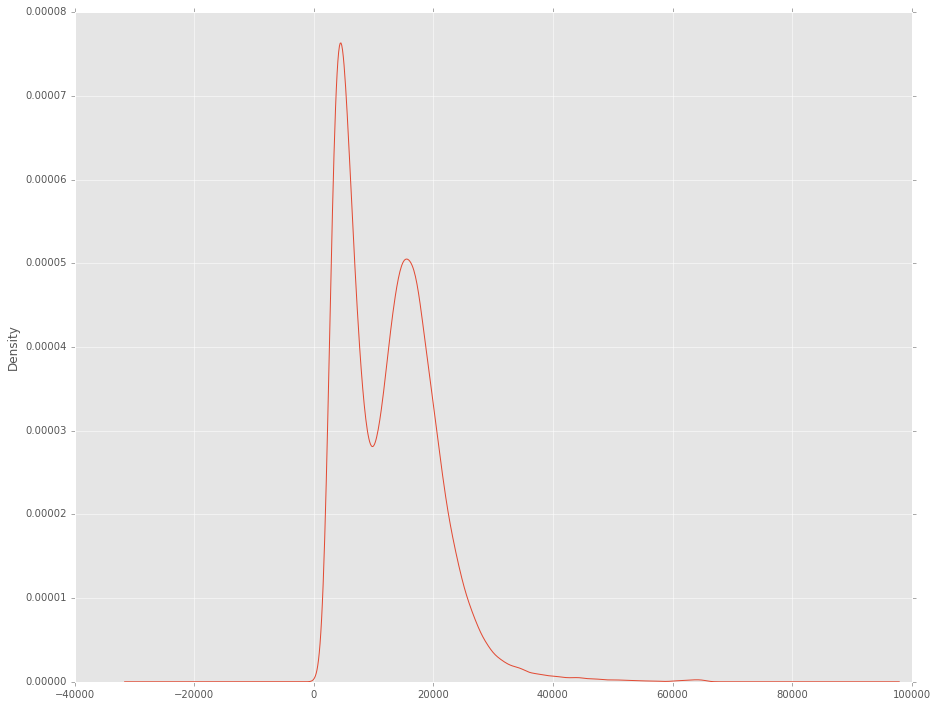

In [20]:
d.Signal_Mean.plot(kind='density')

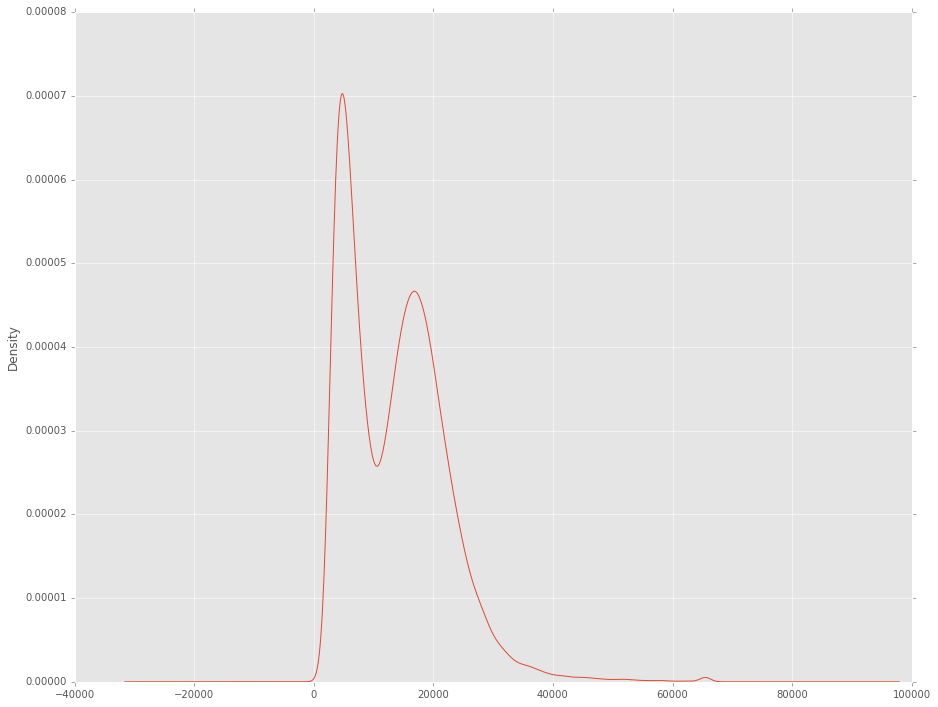

In [19]:
d.Signal_Median.plot(kind='density')

In [21]:
train.head()

,TF_Id,ArrayType,Sequence,Signal_Mean,Background_Mean,Signal_Median,Background_Median,Signal_Std,Background_Std,Flag
1212840,Sox14,HK,AAAAAACAACAGGAGGGCATCATGGAGCTGTCCAGCCTGTGTGAAA...,4689.7988,728.5694,5097.0,421.5,1215.5156,795.3395,0
1212841,Sox14,HK,AAAAAACAGCCGGATCACAATTTTGCCGAGAGCGACCTGTGTGAAA...,7601.9057,1117.3750,8022.0,446.5,1220.7102,1297.0731,0
1212842,Sox14,HK,AAAAAACGTCCGGTACACCCCGTTCGGCGGCCCAGCCTGTGTGAAA...,3450.9868,460.4931,3810.5,264.5,980.1734,522.8422,0
1212843,Sox14,HK,AAAAAACTCTAGACCTTTAGCCCATCGTTGGCCAACCTGTGTGAAA...,6405.0585,852.9558,6765.0,354.0,1394.2091,1071.4765,0
1212844,Sox14,HK,AAAAAAGAACAACCGGATAACACCCTTACAGCACACCTGTGTGAAA...,7719.7729,631.4874,8300.0,288.5,2351.0661,923.0020,0


In [26]:
# train.Sequence.str.len()

## Sequential Model- Character level RNN

In [48]:
class CharRNN(nn.Module):
    
    def __init__(self, batch_size, num_tokens, embed_size, gru_hidden_size):
        
        super(CharRNN, self).__init__()
        
        self.num_tokens = num_tokens
        self.embed_size = embed_size
        self.gru_hidden_size = gru_hidden_size
        self.batch_size = batch_size
        
        self.look_up = nn.Embedding(num_tokens, embed_size)
        self.char_gru = nn.GRU(embed_size, gru_hidden_size, bidirectional= True)
        self.linear_map = nn.Linear(2 * gru_hidden_size, 1)
    
    def forward(self, embed, state_char):
        
        embedded = self.look_up(embed)
#         print embedded.size()
        gru_vectors, state_char = self.char_gru(embedded.transpose(1,0), state_char)
        # get the last gru vector
        gru_vector = gru_vectors[-1]
        # do a linear map
        mapped_output = self.linear_map(gru_vector)
        return mapped_output
    
    def init_hidden(self):
        
        return Variable(torch.zeros(2, self.batch_size, self.gru_hidden_size))

### Fake input validation

In [49]:
fake_seq_batch = Variable(torch.from_numpy(np.random.randint(0,3, (64, 60))))

In [50]:
fake_model = CharRNN(batch_size= 64, num_tokens=4, embed_size=300, gru_hidden_size=100)

In [51]:
fake_model

CharRNN (
  (look_up): Embedding(4, 300)
  (char_gru): GRU(300, 100, bidirectional=True)
  (linear_map): Linear (200 -> 1)
)

In [52]:
fake_state_char = fake_model.init_hidden()

In [53]:
fake_model(fake_seq_batch, fake_state_char)

Variable containing:
-0.2736
-0.2537
-0.1098
 0.1242
 0.0753
-0.1373
 0.0294
-0.0499
-0.0016
 0.1113
 0.0331
 0.1487
-0.0822
-0.3036
-0.2464
-0.1634
-0.1137
-0.2822
-0.2116
 0.1234
 0.1061
-0.0399
-0.2840
-0.1661
-0.0507
-0.2350
 0.1519
-0.0992
 0.0976
 0.0823
-0.0038
 0.0521
-0.1613
-0.2759
-0.0964
 0.0461
 0.0382
-0.0489
 0.1190
 0.0608
 0.0354
 0.0344
 0.1500
 0.1919
 0.0045
-0.1330
-0.1812
-0.3520
-0.0923
-0.1117
-0.1924
-0.0264
 0.0437
-0.2183
 0.0489
-0.1921
-0.0433
 0.1571
 0.0755
 0.1516
-0.0946
 0.0361
 0.2039
 0.0805
[torch.FloatTensor of size 64x1]

Forward pass working!

## Preparing data

In [54]:
train.head()

,TF_Id,ArrayType,Sequence,Signal_Mean,Background_Mean,Signal_Median,Background_Median,Signal_Std,Background_Std,Flag
1212840,Sox14,HK,AAAAAACAACAGGAGGGCATCATGGAGCTGTCCAGCCTGTGTGAAA...,4689.7988,728.5694,5097.0,421.5,1215.5156,795.3395,0
1212841,Sox14,HK,AAAAAACAGCCGGATCACAATTTTGCCGAGAGCGACCTGTGTGAAA...,7601.9057,1117.3750,8022.0,446.5,1220.7102,1297.0731,0
1212842,Sox14,HK,AAAAAACGTCCGGTACACCCCGTTCGGCGGCCCAGCCTGTGTGAAA...,3450.9868,460.4931,3810.5,264.5,980.1734,522.8422,0
1212843,Sox14,HK,AAAAAACTCTAGACCTTTAGCCCATCGTTGGCCAACCTGTGTGAAA...,6405.0585,852.9558,6765.0,354.0,1394.2091,1071.4765,0
1212844,Sox14,HK,AAAAAAGAACAACCGGATAACACCCTTACAGCACACCTGTGTGAAA...,7719.7729,631.4874,8300.0,288.5,2351.0661,923.0020,0


In [55]:
vocab = {'A':0,'C':1,'T':2,'G':3}

In [60]:
sequence_encoded = [vocab[x] for x in list(train.Sequence.iloc[0])]

In [62]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [92]:
def gen_minibatch(tokens, labels, mini_batch_size, shuffle= False):
    for token, label in iterate_minibatches(tokens, labels, mini_batch_size, shuffle= False):
        token = gen_sequences(token)
        yield token, Variable(torch.from_numpy(label), requires_grad= False)

In [93]:
tokens = train.Sequence.values

In [94]:
labels = train.Signal_Mean.values

In [95]:
tokens[0:10]

array(['AAAAAACAACAGGAGGGCATCATGGAGCTGTCCAGCCTGTGTGAAATTGTTATCCGCTCT',
       'AAAAAACAGCCGGATCACAATTTTGCCGAGAGCGACCTGTGTGAAATTGTTATCCGCTCT',
       'AAAAAACGTCCGGTACACCCCGTTCGGCGGCCCAGCCTGTGTGAAATTGTTATCCGCTCT',
       'AAAAAACTCTAGACCTTTAGCCCATCGTTGGCCAACCTGTGTGAAATTGTTATCCGCTCT',
       'AAAAAAGAACAACCGGATAACACCCTTACAGCACACCTGTGTGAAATTGTTATCCGCTCT',
       'AAAAAAGCTAAATCTCACTACTATCAACCACGTGCCCTGTGTGAAATTGTTATCCGCTCT',
       'AAAAAATCGGCGCTCGCACAATAACACTTGGACCACCTGTGTGAAATTGTTATCCGCTCT',
       'AAAAAATGGGCGTAAGCGTATTAGGTGGGAACCACCCTGTGTGAAATTGTTATCCGCTCT',
       'AAAAACATATTTTTAAGCCCCATTGCGATCCAGCTCCTGTGTGAAATTGTTATCCGCTCT',
       'AAAAACCCCAGAAAGGTTGACTAGAGTAAATCTCCCCTGTGTGAAATTGTTATCCGCTCT'], dtype=object)

In [96]:
def gen_sequences(tokens):
    encoded  = []
    for t in tokens:
        encoded.append([vocab[x] for x in list(t)])
    return Variable(torch.from_numpy(np.array(encoded)))

In [97]:
# gen_sequences(tokens[0:10])

In [88]:
# g = gen_minibatch(tokens, labels, 64)

In [89]:
# t, l = next(g)